# Homework 4 - Applied ML
## Exercise 1

Our goal for this exercise is to predict the skin color of a soccer player given  his description. We will use a Random Forest Classifier and discuss the importance of each feature of the dataset.

In [1]:
# Standard imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') # for cleaner output

In [2]:
import sklearn.ensemble
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing

### Cleaning the Data

In [3]:
df_raw = pd.read_csv('CrowdstormingDataJuly1st.csv')
df_raw.shape

(146028, 28)

First, we discard all the rows which have no data for the columns rater1 and rater2 and then we compute the mean of the raters to obtain a value between 0 and 1 which we define as the skin colour.

In [4]:
df = df_raw.dropna(subset=['rater1', 'rater2'])

In [5]:
df['skin_colour'] = df[['rater1', 'rater2']].mean(axis=1)
df = df.drop(['rater1', 'rater2'], axis=1)
df.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skin_colour
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0.375
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,0.750
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.000


Here are the columns for each dyad, we will keep only the revelent ones for the rest of the exercise. Since we are interested in the characteristics of each player, we drop the columns related to the referee.

In [6]:
df.columns

Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'refNum',
       'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp',
       'seExp', 'skin_colour'],
      dtype='object')

Then we group the data by player and we use the operator max() to keep the value with the maximum number of occurences for the categorical values and we add the numerical values such as the number of games.

In [7]:
df_playergr1 = df[['playerShort', 'club', 'leagueCountry',
                   'height', 'weight', 'position', 'skin_colour']].groupby('playerShort').max()
df_playergr2 = df[['playerShort', 'games', 'victories', 'ties', 'defeats', 'goals',
                   'yellowCards', 'yellowReds', 'redCards']].groupby('playerShort').sum()
df_player = pd.concat([df_playergr1, df_playergr2], axis=1)
df_player.head()

,club,leagueCountry,height,weight,position,skin_colour,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards
playerShort,,,,,,,,,,,,,,
aaron-hughes,Fulham FC,England,182.0,71.0,Center Back,0.125,654,247,179,228,9,19,0,0
aaron-hunt,Werder Bremen,Germany,183.0,73.0,Attacking Midfielder,0.125,336,141,73,122,62,42,0,1
aaron-lennon,Tottenham Hotspur,England,165.0,63.0,Right Midfielder,0.250,412,200,97,115,31,11,0,0
aaron-ramsey,Arsenal FC,England,178.0,76.0,Center Midfielder,0.000,260,150,42,68,39,31,0,1
abdelhamid-el-kaoutari,Montpellier HSC,France,180.0,73.0,Center Back,0.250,124,41,40,43,1,8,4,2


Here are some plots to have a first look at the possible correlations between the skin color and the others features of the dataframe.

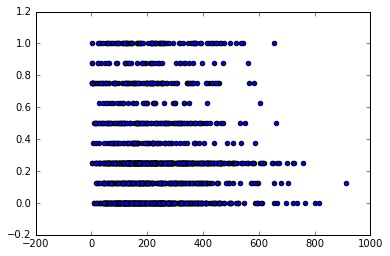

In [8]:
plt.scatter(df_player.games, df_player.skin_colour)

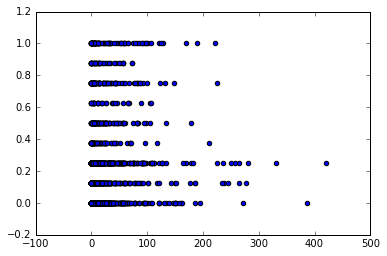

In [9]:
plt.scatter(df_player.goals, df_player.skin_colour)

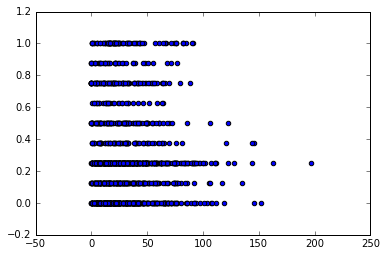

In [10]:
plt.scatter(df_player.yellowCards, df_player.skin_colour)

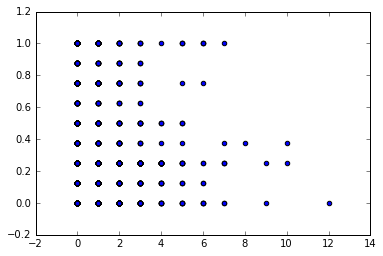

In [11]:
plt.scatter(df_player.yellowReds, df_player.skin_colour)

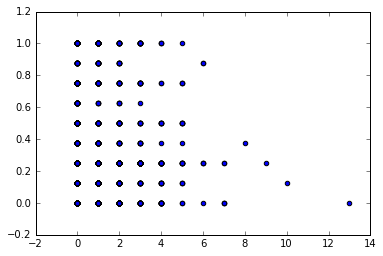

In [12]:
plt.scatter(df_player.redCards, df_player.skin_colour)

We can not see any obvious correlation between the values but we can notice that there are much more player with a fairer skin tone and thus the data are skwed. 

We can see that they are still some columns with NaN values, we decided to drop the rows which have no weight or height since there are very few of them. We replace the NaN values in the position column by "No Info" so that they will be properly encoded later. 

In [13]:
df_player.isnull().sum()

club               0
leagueCountry      0
height             3
weight            21
position         152
skin_colour        0
games              0
victories          0
ties               0
defeats            0
goals              0
yellowCards        0
yellowReds         0
redCards           0
dtype: int64

In [14]:
df_player.position = df_player[['position']].fillna('No Info')
df_player = df_player.dropna(subset=['height', 'weight'])

As suspected before, we can see that there are fewer players with a darak skin tone. Thus, the distribution is skewed and we must be carefull with our results.

In [33]:
df_player['skin_colour'].value_counts()

0.250    466
0.000    418
0.125    225
0.500    115
0.750    100
1.000     90
0.375     77
0.875     40
0.625     33
Name: skin_colour, dtype: int64

We decided to use 3 classifications models. 
- The first one is a binary model where all skin_colour values below 0.5 are considered white and all above black. The players with skin_colour value exactly 0.5 are dropped.
- The second one is a ternary model. The players with skin_colour values in [0, 0.25] are in the first category, the second catergory is composed of the players with skin_colour values in ]0.25, 0.75[ and finally the players with skin_colour values greater or equal to 0.75 are in the third category.  
- The last model consider the 9 category produced by the mean of the two raters.

In [16]:
df_player_bin = df_player.copy()
df_player_ter = df_player.copy()
df_player_all = df_player.copy()

In [17]:
# Binary Classification (removing 0.5 and sorting the values)
df_player_bin = df_player_bin[df_player_bin['skin_colour'] != 0.5]
df_player_bin.loc[df_player_bin.skin_colour < 0.5, 'skin_colour'] = 0
df_player_bin.loc[df_player_bin.skin_colour > 0.5, 'skin_colour'] = 1
df_player_bin.head(5)

,club,leagueCountry,height,weight,position,skin_colour,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards
playerShort,,,,,,,,,,,,,,
aaron-hughes,Fulham FC,England,182.0,71.0,Center Back,0.0,654,247,179,228,9,19,0,0
aaron-hunt,Werder Bremen,Germany,183.0,73.0,Attacking Midfielder,0.0,336,141,73,122,62,42,0,1
aaron-lennon,Tottenham Hotspur,England,165.0,63.0,Right Midfielder,0.0,412,200,97,115,31,11,0,0
aaron-ramsey,Arsenal FC,England,178.0,76.0,Center Midfielder,0.0,260,150,42,68,39,31,0,1
abdelhamid-el-kaoutari,Montpellier HSC,France,180.0,73.0,Center Back,0.0,124,41,40,43,1,8,4,2


In [18]:
# Ternary Classification (3 groups of 3 values)
df_player_ter.loc[df_player_ter.skin_colour <= 0.25, 'skin_colour'] = -1
df_player_ter.loc[df_player_ter.skin_colour >= 0.75, 'skin_colour'] = 1
df_player_ter.loc[(df_player_ter.skin_colour > 0.25) & (df_player_ter.skin_colour < 0.75), 'skin_colour'] = 0
df_player_ter.head(5)

,club,leagueCountry,height,weight,position,skin_colour,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards
playerShort,,,,,,,,,,,,,,
aaron-hughes,Fulham FC,England,182.0,71.0,Center Back,-1.0,654,247,179,228,9,19,0,0
aaron-hunt,Werder Bremen,Germany,183.0,73.0,Attacking Midfielder,-1.0,336,141,73,122,62,42,0,1
aaron-lennon,Tottenham Hotspur,England,165.0,63.0,Right Midfielder,-1.0,412,200,97,115,31,11,0,0
aaron-ramsey,Arsenal FC,England,178.0,76.0,Center Midfielder,-1.0,260,150,42,68,39,31,0,1
abdelhamid-el-kaoutari,Montpellier HSC,France,180.0,73.0,Center Back,-1.0,124,41,40,43,1,8,4,2


In [19]:
df_player_all.skin_colour = df_player_all.skin_colour * 8
df_player_all.head(5)

,club,leagueCountry,height,weight,position,skin_colour,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards
playerShort,,,,,,,,,,,,,,
aaron-hughes,Fulham FC,England,182.0,71.0,Center Back,1.0,654,247,179,228,9,19,0,0
aaron-hunt,Werder Bremen,Germany,183.0,73.0,Attacking Midfielder,1.0,336,141,73,122,62,42,0,1
aaron-lennon,Tottenham Hotspur,England,165.0,63.0,Right Midfielder,2.0,412,200,97,115,31,11,0,0
aaron-ramsey,Arsenal FC,England,178.0,76.0,Center Midfielder,0.0,260,150,42,68,39,31,0,1
abdelhamid-el-kaoutari,Montpellier HSC,France,180.0,73.0,Center Back,2.0,124,41,40,43,1,8,4,2


Then we drop the skin_colour column to obtain an unlabelled dataframe almost ready to be trained.

In [20]:
df_ml_bin = df_player_bin.drop('skin_colour', axis=1)
df_ml = df_player.drop('skin_colour', axis=1)

We use the encoder from DictVectorizer to transform the categorical data into numbers.

In [24]:
encoder = DictVectorizer(sparse=False)
df_ml_bin_temp = df_ml_bin.convert_objects(convert_numeric=True)
df_ml_bin_temp = encoder.fit_transform(df_ml_bin_temp.to_dict(orient='records'))

df_ml_temp = df_ml.convert_objects(convert_numeric=True)
df_ml_temp = encoder.fit_transform(df_ml_temp.to_dict(orient='records'))

In [25]:
encoder.feature_names_

['club=1. FC Nürnberg',
 'club=1. FSV Mainz 05',
 'club=1899 Hoffenheim',
 'club=AC Ajaccio',
 'club=AS Nancy',
 'club=AS Saint-Étienne',
 'club=Arsenal FC',
 'club=Arsenal FC (R)',
 'club=Aston Villa',
 'club=Athletic Bilbao',
 'club=Atlético Madrid',
 'club=Bayer Leverkusen',
 'club=Bayern München',
 'club=Blackburn Rovers',
 'club=Bolton Wanderers',
 'club=Bor. Mönchengladbach',
 'club=Borussia Dortmund',
 'club=CA Osasuna',
 'club=CF Badalona',
 'club=Celta Vigo',
 'club=Chelsea FC',
 'club=Crewe Alexandra',
 'club=Deportivo La Coruña',
 'club=ESTAC Troyes',
 'club=Eintracht Frankfurt',
 'club=Espanyol Barcelona',
 'club=Everton FC',
 'club=FC Augsburg',
 'club=FC Barcelona',
 'club=FC Lorient',
 'club=FC Schalke 04',
 'club=FC Sochaux',
 'club=Fortuna Düsseldorf',
 'club=Fulham FC',
 'club=Getafe CF',
 'club=Girondins Bordeaux',
 'club=Granada CF',
 'club=Hamburger SV',
 'club=Hannover 96',
 'club=Leeds United',
 'club=Leicester City',
 'club=Levante UD',
 'club=Leyton Orient',
 '

The last operation before the training is the scaling of the data.

In [26]:
ml_scaled_bin = preprocessing.scale(df_ml_bin_temp)
df_ml_scaled_bin = pd.DataFrame(ml_scaled_bin)

ml_scaled = preprocessing.scale(df_ml_temp)
df_ml_scaled = pd.DataFrame(ml_scaled)

Then we split our test into a training and a test set with ratio 0.2.

In [27]:
#Selecting a training set (binary)
x_train_bin, x_test_bin, y_train_bin, y_test_bin = train_test_split(df_ml_scaled_bin, df_player_bin.skin_colour, test_size=0.2, random_state = 0)
x_train_ter, x_test_ter, y_train_ter, y_test_ter = train_test_split(df_ml_scaled, df_player_ter.skin_colour, test_size=0.2, random_state = 0)
x_train_all, x_test_all, y_train_all, y_test_all = train_test_split(df_ml_scaled, df_player_all.skin_colour, test_size=0.2, random_state = 0)

To obtain the best model possible, we tried several parameters and we used a gridSearch to get the best ones using 5 cross-validations.

In [28]:
param_grid = [
    {'n_estimators': [10,15,20,25,30,40,50,75,100, 125], 'criterion': ['gini', 'entropy'], 'max_features': ['sqrt', 'log2']}
]

In [29]:
from sklearn.grid_search import GridSearchCV

In [30]:
from sklearn.ensemble import RandomForestClassifier
rfc_bin = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5)
rfc_ter = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5)
rfc_all = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5)

rfc_bin.fit(x_train_bin, y_train_bin)
rfc_ter.fit(x_train_ter, y_train_ter)
rfc_all.fit(x_train_all, y_train_all)

print('Binary Best Score : ' + str(rfc_bin.best_score_))
print('Ternary Best Score : ' + str(rfc_ter.best_score_))
print('All params Best Score : ' + str(rfc_all.best_score_))

print('Binary Best Parameters : ' + str(rfc_bin.best_params_))
print('Ternary Best Parameters : ' + str(rfc_ter.best_params_))
print('All params Best Parameters : ' + str(rfc_all.best_params_))

Binary Best Score : 0.822260569456
Ternary Best Score : 0.713828936851
All params Best Score : 0.33653077538
Binary Best Parameters : {'max_features': 'log2', 'criterion': 'gini', 'n_estimators': 25}
Ternary Best Parameters : {'max_features': 'sqrt', 'criterion': 'gini', 'n_estimators': 30}
All params Best Parameters : {'max_features': 'sqrt', 'criterion': 'entropy', 'n_estimators': 100}


The scores above are way too large and if we take a closer look at the data, we have already noticed that the distribution is skewed. In this case, it is better to use a f1 scoring function which penalizes more the false positives and the true negatives. With this new scoring function, we can see that the score is far worse and in accordance to the confusion matrix.

In [31]:
rfc_bin = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5, scoring='f1')
rfc_bin.fit(x_train_bin, y_train_bin)
print('Binary Score : ' + str(rfc_bin.best_score_))

Binary Score : 0.192248809833


In [32]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test_bin, rfc_bin.predict(x_test_bin))

array([[237,   4],
       [ 38,  11]])